Generate both a CaSR climatological mean map and one from database winds.

Interpolation is carried out on both datasets to a common grid. 
Note: it is not recommended to use this tool over all of Canada - it takes too long and the wind interpolation especially from the observed winds will result in discrepancies. 

There are several predefined averaging areas that can be used. Or you can draw your own using a built in map function.

Liam.Buchart@nrcan-rncan.gc.ca
October 6, 2025

In [37]:
# start with a widget to choose whether we are comparing stations data or just a point location on a map
import ipywidgets as widgets
from IPython.display import display
from scipy.interpolate import griddata

import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import xarray as xr
import ipywidgets as widgets
import os
import json

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# load the json
with open("regions_bbox_canada.json", 'r') as f:
    regions_data = json.load(f)

region_names = sorted( [region["name"] for region in regions_data["regions"]] )

In [38]:
# two selectors for the month and year
Averaging_Select = widgets.Dropdown(
    options=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "DJF", "MAM", "JJA", "SON"], 
    value="7",
    description='Period:',
    )

Year_Select = widgets.Dropdown(
    options=np.arange(2022, 2025+1),
    value=2025,
    description='Year:',
    )

Region_Select = widgets.Dropdown(
    options=region_names,
    value="Prairies",
    description="Region:"
)

Interp_Select = widgets.Dropdown(
    options=["Cubic", "Linear", "Nearest"],
    value="Linear",
    description="Interpolation Method:"
)

print("When selecting interpolation method...")
print("Cubis is nicer but not great over the larger bounding boxes, defauly to Linear")
display(Averaging_Select, Year_Select, Region_Select, Interp_Select)

When selecting interpolation method...
Cubis is nicer but not great over the larger bounding boxes, defauly to Linear


Dropdown(description='Period:', index=6, options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12…

Dropdown(description='Year:', index=3, options=(np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)…

Dropdown(description='Region:', index=5, options=('Atlantic Canada', 'British Columbia', 'Canadian Rockies', '…

Dropdown(description='Interpolation Method:', index=1, options=('Cubic', 'Linear', 'Nearest'), value='Linear')

In [39]:
# define the grid depending on the Region_Select dropdown
selected_region = Region_Select.value
bounds = next(region["bbox"] for region in regions_data["regions"] if region["name"] == selected_region)

min_lon = bounds["west"] 
max_lon = bounds["east"] # convert to the casr longitude coordinate

min_lat = bounds["south"]
max_lat = bounds["north"]

xi = np.arange(min_lon, max_lon, 0.1)
yi = np.arange(min_lat, max_lat, 0.1)

xi, yi = np.meshgrid(xi, yi)

print("Comparison Grid is Ready...")

# get the text name of the month from period if period is a number
period = Averaging_Select.value
if period in [str(i) for i in range(1,13)]:
    month_name = pd.to_datetime(period, format='%m').strftime('%B')
else:
    month_name = period

Comparison Grid is Ready...


In [40]:
# climatological CaSR grid which is saved in 
def sort_files(dir, Astr):
    all_files = os.listdir(dir)

    day_files = [file for file in all_files if f"{str(Astr)}.h5" in file]

    return day_files

# hacky means of determining if this is a seasonal or monthly average
if Averaging_Select.value.isalpha():
    data_dir = "../climatology/seasonal/"
    p_file = sort_files(data_dir, Averaging_Select.value)

    # load the json
    with open("regions_bbox_canada.json", 'r') as f:
        season_data = json.load(f)

    months = next(season["months"] for season in season_data["seasons"] if season["name"] == Averaging_Select.value)
    mstart = months["mstart"]
    mend = months["mend"]

    sfile = f"1990-2020_seasonal_windspeed_stats_{Averaging_Select.value}.nc"
    dfile = f"1990-2020_seasonal_winddirection_stats_{Averaging_Select.value}.nc"
    
elif Averaging_Select.value.isdigit():
    data_dir = "../climatology/monthly"
    mstr = f"{int(Averaging_Select.value):02d}"
    p_file = sort_files(data_dir, mstr)

    # save some query variables
    mstart = mstr
    mend = mstr

    sfile = f"1990-2020_monthly_windspeed_stats_m{mstr}.nc"
    dfile = f"1990-2020_monthly_winddirection_stats_m{mstr}.nc"

else:
    data_dir = "Something has gone wrong"

# extract the monthly or seasonal file
casr_speed = xr.open_dataset(f"{data_dir}/{sfile}")
casr_direction = xr.open_dataset(f"{data_dir}/{dfile}")

# drop down with all the variables from the files (just need to grab one)
all_vars = list(casr_speed.keys())
Variable_Select = widgets.Dropdown(
    options=all_vars,
    value="mean",
    description="Plot Var:"
)

display(Variable_Select)

Dropdown(description='Plot Var:', options=('mean', 'median', 'std', 'p10', 'p25', 'p75', 'p90', 'p95', 'max'),…

rows after removing NaNs: 233531


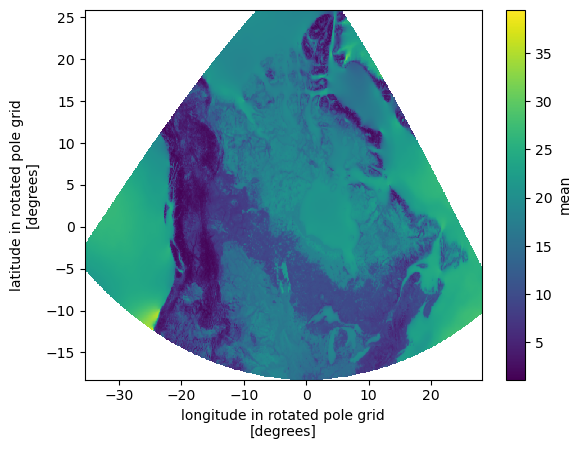

In [41]:
# quick plot of the mean wind speed using xarray's built in plotter
casr_speed[str(Variable_Select.value)].plot()

# process the casr data so it can be regridded
casr_dir = casr_direction[str(Variable_Select.value)]  #.sel(rlat=slice(min_lat, max_lat), rlon=slice(min_lon, max_lon)) 
casr_spd = casr_speed[str(Variable_Select.value)]  #.sel(rlat=slice(min_lat, max_lat), rlon=slice(min_lon, max_lon))

# also get the standard deviations for both speed and direction if needed later
casr_dir_std = casr_direction["std"].values.ravel()
casr_spd_std = casr_speed["std"].values.ravel()

lons = casr_dir["lon"].values.ravel()
lats = casr_dir["lat"].values.ravel()
dirs = casr_dir.values.ravel()
speeds = casr_spd.values.ravel()

casr_dictionary = {"lons": lons-360, 
                   "lats": lats, 
                   "dir": dirs, 
                   "speed": speeds,
                   "dir_std": casr_dir_std,
                   "spd_std": casr_spd_std}
casr_df = pd.DataFrame(casr_dictionary)

valid = np.isfinite(casr_df[["lons","lats","speed"]]).all(axis=1)
casr_df = casr_df[valid].reset_index(drop=True)
print("rows after removing NaNs:", len(casr_df))

# remove all values outside the bounding box
casr_df = casr_df[casr_df["lats"] > min_lat]
casr_df = casr_df[casr_df["lats"] < max_lat]

casr_df = casr_df[casr_df["lons"] > min_lon]
casr_df = casr_df[casr_df["lons"] < max_lon]

In [42]:
# query the database for all station data over our averaging period
from etl_station_data import db_query, set_areal_query, last_day_of_month
query = set_areal_query(int(mstart), int(mend), Year_Select.value, bounds)
print(f"SQL Query: {query}")
query_file = f"m{mstr}_{Region_Select.value}_query_output.csv"

# execute the query on dagan
db_query(query, csv_output=f"./output/{query_file}")

SELECT cwfis_allstn2025.aes, rep_date, lat, lon, elev, ws, wg, wdir FROM cwfis_allstn2025, can_hly2020s WHERE cwfis_allstn2025.aes in (SELECT aes FROM cwfis_allstn2025 WHERE lon BETWEEN -124.2 AND -110.8 AND lat BETWEEN 47.8 AND 56.2) AND rep_date BETWEEN '2025-06-01 00:00:00' AND '2025-06-30 23:00:00' AND cwfis_allstn2025.aes = can_hly2020s.aes ORDER BY rep_date, cwfis_allstn2025.aes;
SQL Query: SELECT cwfis_allstn2025.aes, rep_date, lat, lon, elev, ws, wg, wdir FROM cwfis_allstn2025, can_hly2020s WHERE cwfis_allstn2025.aes in (SELECT aes FROM cwfis_allstn2025 WHERE lon BETWEEN -124.2 AND -110.8 AND lat BETWEEN 47.8 AND 56.2) AND rep_date BETWEEN '2025-06-01 00:00:00' AND '2025-06-30 23:00:00' AND cwfis_allstn2025.aes = can_hly2020s.aes ORDER BY rep_date, cwfis_allstn2025.aes;
SSH tunnel established
('s-edm-genii', 59096)
Connecting to database cwfis as user fire
Query results saved to ./output/m06_Canadian Rockies_query_output.csv


         aes    date       lon      lat         ws        wdir
0    1012475  2025-0  -123.233   48.417  10.648883  223.905028
1    1012710  2025-0  -123.433   48.433  11.501806    188.9625
2    1013998  2025-0 -123.2369  48.5476  13.979944  178.842618
3    1015630  2025-0  -123.717   48.817   3.593741  180.246175
4    1016640  2025-0  -123.533     48.3  29.766667  250.438889
..       ...     ...       ...      ...        ...         ...
203  1176745  2025-0  -118.183   50.967   6.683428  205.365439
204  3065997  2025-0  -114.783     55.3  12.482184  221.444444
205  1018619  2025-0  -123.383   48.417  14.828947  211.421053
206  1126511  2025-0  -120.517   49.467   7.726087  154.565217
207  3033890  2025-0  -112.767     49.7  13.888851  190.469983

[208 rows x 6 columns]


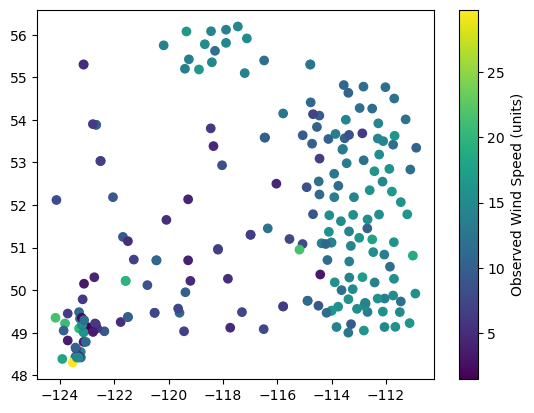

In [43]:
# open the queried file using pandas
obs_winds = pd.read_csv(f"./output/{query_file}")

# drop wg (wind gust) column 
obs_winds = obs_winds.drop(columns=["wg"], errors='ignore')

# remove all rows with NaN values
obs_winds = obs_winds.dropna()

obs_winds_means = pd.DataFrame(columns=["aes", "date", "lon", "lat", "ws", "wdir"])
aes_unique = obs_winds["aes"].unique()

# add the unique aes to the means dataframe
obs_winds_means["aes"] = aes_unique

# loop through the means dataframe and populate with the duration averages
for row, index in obs_winds_means.iterrows():
    station = index["aes"]
    station_data = obs_winds[obs_winds["aes"] == station]
    mean_date = station_data["rep_date"].iloc[0][0:6]  # assuming all dates are the same for the averaging period just the YYYY-MM
    mean_lon = station_data["lon"].mean()
    mean_lat = station_data["lat"].mean()
    mean_ws = station_data["ws"].mean()
    mean_wdir = station_data["wdir"].mean()

    obs_winds_means.at[row, "date"] = mean_date
    obs_winds_means.at[row, "lon"] = mean_lon
    obs_winds_means.at[row, "lat"] = mean_lat
    obs_winds_means.at[row, "ws"] = mean_ws
    obs_winds_means.at[row, "wdir"] = mean_wdir

print(obs_winds_means)
# contour plot of the observed wind speeds
# imshow of the wind speed interpolation
import matplotlib.pyplot as plt
plt.scatter(obs_winds_means["lon"], obs_winds_means["lat"], c=obs_winds_means["ws"], cmap='viridis')
plt.colorbar(label='Observed Wind Speed (units)')
plt.show()


In [44]:
def regrid_data(xo, yo, zo, xint, yint, method):
    # xo, yo, zo = grids of input data
    # xi, yi = grid to interpolate onto
    # method = string (linear, nearest, cubic)
    
    # convert xo, yo, zo to arrays
    xo = np.array(xo)
    yo = np.array(yo)
    zo = np.array(zo)

    return griddata((xo, yo), zo, (xint, yint), method=method)

# interpolate these winds onto the previously created grid
wsi = regrid_data(list(obs_winds_means["lon"]), list(obs_winds_means["lat"]),
                  list(obs_winds_means["ws"]),
                  xi, yi, 
                  method=Interp_Select.value.lower())

wdi = regrid_data(list(obs_winds_means["lon"]), list(obs_winds_means["lat"]),
                  list(obs_winds_means["wdir"]),
                  xi, yi, 
                  method=Interp_Select.value.lower())



In [45]:
# carry out a similar process on the casr data that has been extracted.
with open("../utils/variables.json", 'r') as f:
    casr_vars = json.load(f)

casr_wsi = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["speed"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

casr_wdi = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["dir"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

# interpolate the stds
casr_wdi_std = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["dir_std"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

casr_wsi_std = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["spd_std"]),
                       xi, yi,
                       method=Interp_Select.value.lower())


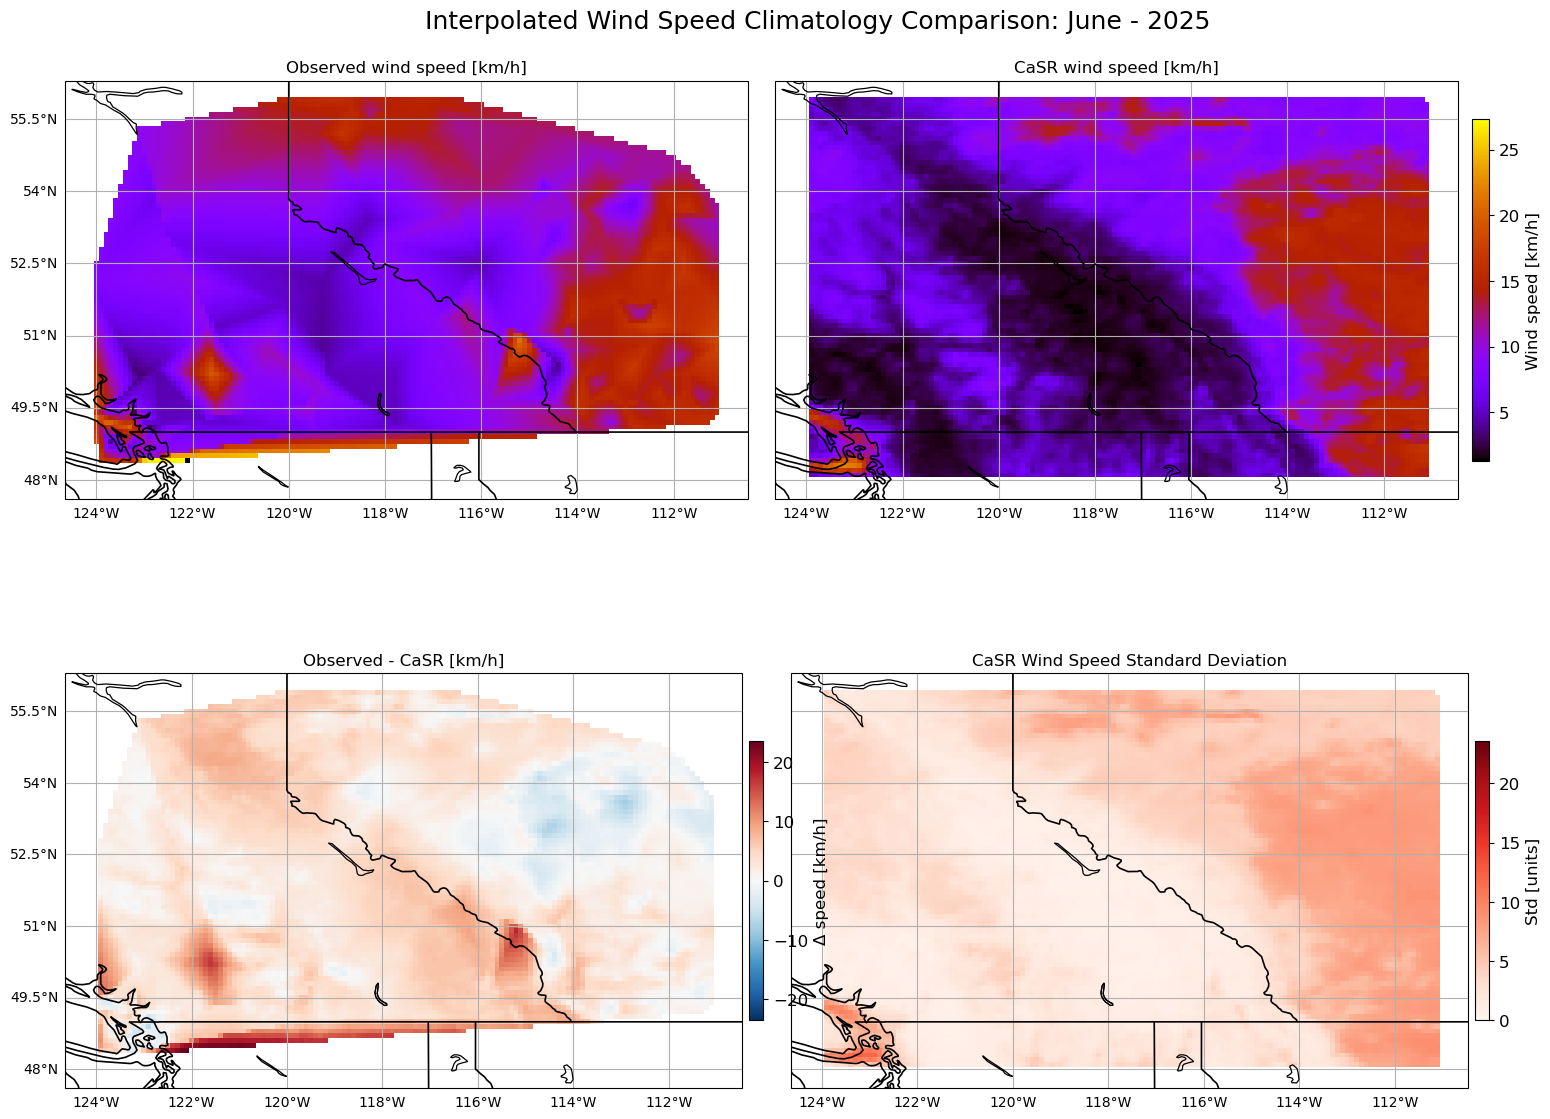

In [ ]:
# matplotlib contour plots of the regridded data, difference, and standard devatation in 4 subfigures
# assumes xi, yi, wsi, casr_wsi, casr_wsi_std exist (2D arrays with same shape)

# helper to draw common map features
def prettify(ax):
    # draw features on top of plotted data
    ax.coastlines(resolution='50m', linewidth=1.2, color='k', zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.2, edgecolor='k', zorder=6)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='none', edgecolor='k', linewidth=0.9, zorder=7)
    provinces = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m')
    ax.add_feature(provinces, edgecolor='k', facecolor='none', linewidth=1.2, zorder=8)

    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    # hide the lat labels on the right columns to clean it up
    gl.left_labels = False if ax in [axs[0,1], axs[1,1]] else True

# compute extent and small padding
lonmin, lonmax = float(np.nanmin(xi)), float(np.nanmax(xi))
latmin, latmax = float(np.nanmin(yi)), float(np.nanmax(yi))
pad_lon = 0.05 * (lonmax - lonmin) if lonmax>lonmin else 0.5
pad_lat = 0.05 * (latmax - latmin) if latmax>latmin else 0.5
extent = [lonmin - pad_lon, lonmax + pad_lon, latmin - pad_lat, latmax + pad_lat]

# mask
wsi_m = np.ma.masked_invalid(wsi)
casr_m = np.ma.masked_invalid(casr_wsi)
std_m = np.ma.masked_invalid(casr_wsi_std)
diff_m = np.ma.masked_invalid(wsi - casr_wsi)

# unified color limits for observed and CaSR
shared_vals = np.hstack([arr.compressed() for arr in (wsi_m, casr_m) if arr is not None and arr.size])
if shared_vals.size:
    shared_vmin, shared_vmax = float(np.nanmin(shared_vals)), float(round(np.nanmax(shared_vals), 5))
else:
    shared_vmin, shared_vmax = 0.0, 1.0

# determine positive-difference max for std panel scaling
pos_diff = diff_m.copy()
try:
    pos_mask = pos_diff > 0
    if np.any(pos_mask):
        pos_max = float(np.nanmax(pos_diff[pos_mask]))
    else:
        pos_max = 0.0
except Exception:
    pos_max = 0.0

# if pos_max is zero/falsy fall back to shared_vmax to avoid degenerate colorbar
if not pos_max:
    std_vmin, std_vmax = 0.0, shared_vmax
else:
    std_vmin, std_vmax = 0.0, pos_max

# cmap
cmap = plt.colormaps["gnuplot"].with_extremes(under="white", over="black")

# symmetric range for difference
dvals = diff_m.compressed() if diff_m.mask is not None else diff_m.ravel()
if dvals.size:
    dl = max(abs(dvals.min()), abs(dvals.max()))
else:
    dl = 1.0

proj = ccrs.PlateCarree()
# increase figure size and tighten layout to reduce white space
fig, axs = plt.subplots(2, 2, figsize=(16, 12),
                        subplot_kw=dict(projection=proj))
# tighten spacing and margins (reduce vertical gap between rows)
fig.subplots_adjust(wspace=0.04, hspace=0.01, left=0.03, right=0.92, top=0.99, bottom=0.01)

# compute font sizes (increase label fonts by +2)
base_fs = plt.rcParams.get('font.size', 10)
label_fs = int(base_fs) + 2
suptitle_fs = 18

# Observed (interpolated)
im0 = axs[0, 0].pcolormesh(xi, yi, wsi_m, shading='auto', vmin=shared_vmin, vmax=shared_vmax,
                           cmap=cmap, zorder=1)
axs[0, 0].set_title('Observed wind speed [km/h]', fontsize=label_fs)
axs[0, 0].set_xlabel('Longitude', fontsize=label_fs)
axs[0, 0].set_ylabel('Latitude', fontsize=label_fs)
axs[0,0].set_extent(extent, crs=proj)
prettify(axs[0,0])

# CaSR (use same color scale & colorbar as observed)
im1 = axs[0, 1].pcolormesh(xi, yi, casr_m, shading='auto', vmin=shared_vmin, vmax=shared_vmax,
                           cmap=cmap, zorder=1)
axs[0, 1].set_title('CaSR wind speed [km/h]', fontsize=label_fs)
axs[0, 1].set_xlabel('Longitude', fontsize=label_fs)
axs[0, 1].set_extent(extent, crs=proj)
# remove y-axis label text for right-column plot
axs[0, 1].set_ylabel('')
prettify(axs[0,1])

# Difference
im2 = axs[1, 0].pcolormesh(xi, yi, diff_m, cmap='RdBu_r', shading='auto', vmin=-dl, vmax=dl, zorder=1)
axs[1, 0].set_title('Observed - CaSR [km/h]', fontsize=label_fs)
axs[1, 0].set_xlabel('Longitude', fontsize=label_fs)
axs[1, 0].set_ylabel('Latitude', fontsize=label_fs)
axs[1,  0].set_extent(extent, crs=proj)
prettify(axs[1,0])

# CaSR std dev (scale to positive-difference max)
im3 = axs[1, 1].pcolormesh(xi, yi, std_m, shading='auto', vmin=std_vmin, vmax=std_vmax,
                         cmap='Reds', zorder=1)
axs[1, 1].set_title('CaSR Wind Speed Standard Deviation', fontsize=label_fs)
axs[1, 1].set_extent(extent, crs=proj)
axs[1, 1].set_xlabel('Longitude', fontsize=label_fs)
# remove y-axis label text for right-column plot
axs[1, 1].set_ylabel('')
# remove y tick labels
prettify(axs[1,1])

# set tick label sizes for all axes
for ax in axs.flatten():
    ax.tick_params(labelsize=label_fs)

# Shared colorbar for observed & CaSR (top row) — decrease length and keep thin
cbar_shared = fig.colorbar(im0, ax=[axs[0,0], axs[0,1]], orientation='vertical', fraction=0.012, pad=0.01, shrink=0.7)
cbar_shared.set_label('Wind speed [km/h]', fontsize=label_fs)
cbar_shared.ax.tick_params(labelsize=label_fs)

# Colorbar for std (use same numeric range as positive diff)
cbar_std = fig.colorbar(im3, ax=axs[1,1], label=f'Std [ ]', fraction=0.02, pad=0.01)
cbar_std.set_label(f'Std [units]', fontsize=label_fs)
cbar_std.ax.tick_params(labelsize=label_fs)

# Separate colorbar for diff
cbar_diff = fig.colorbar(im2, ax=axs[1,0], fraction=0.02, pad=0.01)  # label='Δ speed [km/h]'
cbar_diff.set_label('Δ speed [km/h]', fontsize=label_fs)
cbar_diff.ax.tick_params(labelsize=label_fs)

fig.suptitle(f'Interpolated Wind Speed Climatology Comparison: {month_name} - {Year_Select.value}', fontsize=suptitle_fs)
plt.show()


In [ ]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Assumes these 2D arrays exist in the environment:
# xi, yi  -> meshgrid of longitudes and latitudes (2D)
# wsi     -> interpolated observed wind speeds on grid (2D, may contain NaN)
# casr_wsi-> CaSR interpolated wind speeds on same grid (2D)
# casr_wsi_std -> CaSR wind speed standard deviation on same grid (2D)
# Averaging_Select -> widget used for title (optional)

# flatten & mask NaNs
lat = yi.flatten()
lon = xi.flatten()
obs_vals = np.asarray(wsi).flatten()
casr_vals = np.asarray(casr_wsi).flatten()
std_vals = np.asarray(casr_wsi_std).flatten()
mask_obs = np.isfinite(obs_vals)
mask_casr = np.isfinite(casr_vals)
mask_std = np.isfinite(std_vals)

# common color limits for observed & CaSR
valid_vals = np.hstack([obs_vals[mask_obs], casr_vals[mask_casr]])
vmin = float(np.nanmin(valid_vals)) if valid_vals.size else 0.0
vmax = float(np.nanmax(valid_vals)) if valid_vals.size else 1.0

# symmetric range for difference
diff = obs_vals - casr_vals
finite_diff = diff[np.isfinite(diff)]
dlim = float(max(abs(np.nanmin(finite_diff)) if finite_diff.size else 0,
                 abs(np.nanmax(finite_diff)) if finite_diff.size else 1.0))

# center & zoom heuristic: compute zoom to fit the full domain
center_lat = float(np.nanmean(lat[np.isfinite(lat)]))
center_lon = float(np.nanmean(lon[np.isfinite(lon)]))
span = max(float(np.nanmax(lon)-np.nanmin(lon)), float(np.nanmax(lat)-np.nanmin(lat)))
if span > 0:
    # approximate zoom that fits the span: larger span -> smaller zoom
    zoom = float(np.clip(np.log2(360.0 / span), 0, 12))
else:
    zoom = 3.0

# create 2x2 mapbox subplots
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}],
           [{"type": "mapbox"}, {"type": "mapbox"}]],
    subplot_titles=["Observed (interpolated) wind speed",
                    "CaSR wind speed",
                    "Observed - CaSR (difference)",
                    "CaSR wind speed standard deviation"]
)

# Observed (shows colorbar)
fig.add_trace(go.Scattermapbox(
    lat=lat[mask_obs],
    lon=lon[mask_obs],
    mode="markers",
    marker=dict(size=4, color=obs_vals[mask_obs],
                colorscale="jet", cmin=vmin, cmax=vmax,
                opacity=0.3),
    name="Observed (interp)",
    hovertemplate="lat=%{lat:.3f}<br>lon=%{lon:.3f}<br>obs=%{marker.color:.2f}<extra></extra>"),
    row=1, col=1)

# CaSR (same color scale, no duplicate colorbar)
fig.add_trace(go.Scattermapbox(
    lat=lat[mask_casr],
    lon=lon[mask_casr],
    mode="markers",
    marker=dict(size=4, color=casr_vals[mask_casr],
                colorscale="jet", cmin=vmin, cmax=vmax,
                opacity=0.3),
    name="CaSR (grid)",
    hovertemplate="lat=%{lat:.3f}<br>lon=%{lon:.3f}<br>casr=%{marker.color:.2f}<extra></extra>"),
    row=1, col=2)

# Difference (RdBu symmetric)
fig.add_trace(go.Scattermapbox(
    lat=lat[np.isfinite(diff)],
    lon=lon[np.isfinite(diff)],
    mode="markers",
    marker=dict(size=4, color=diff[np.isfinite(diff)],
                colorscale="RdBu", cmin=-dlim, cmax=dlim, opacity=0.3),
    name="Obs - CaSR",
    hovertemplate="lat=%{lat:.3f}<br>lon=%{lon:.3f}<br>Δ=%{marker.color:.2f}<extra></extra>"),
    row=2, col=1)

# CaSR std dev
fig.add_trace(go.Scattermapbox(
    lat=lat[mask_std],
    lon=lon[mask_std],
    mode="markers",
    marker=dict(size=4, color=std_vals[mask_std],
                colorscale="Reds", opacity=0.3),
    name="CaSR std",
    hovertemplate="lat=%{lat:.3f}<br>lon=%{lon:.3f}<br>std=%{marker.color:.2f}<extra></extra>"),
    row=2, col=2)

# Layout: configure each mapbox (mapbox, mapbox2, mapbox3, mapbox4)
mapbox_kwargs = dict(style="open-street-map", center=dict(lat=center_lat, lon=center_lon), zoom=zoom)
fig.update_layout(
    mapbox=mapbox_kwargs,         # for row1,col1
    mapbox2=mapbox_kwargs,        # for row1,col2
    mapbox3=mapbox_kwargs,        # for row2,col1
    mapbox4=mapbox_kwargs,        # for row2,col2
    margin=dict(l=5, r=5, t=60, b=5),
    title_text=f"Wind Speed Comparison m{Averaging_Select.value}" if 'Averaging_Select' in globals() else "Wind Speed Comparison"
)

# Hide the default legend (text on the right)
fig.update_layout(showlegend=False)

# Attach individual, positioned colorbars for each subplot
# positions chosen to sit near the right side of each subplot (x,y in figure coordinates)
cb_len = 0.30
cb_thickness = 10
positions = [ (0.36, 0.77),  # row1,col1
              (0.91, 0.77),  # row1,col2
              (0.36, 0.23),  # row2,col1
              (0.91, 0.23) ] # row2,col2
titles = ["Observed wsi", "CaSR wsi", "Δ (Obs-CaSR)", "CaSR std"]
for i, (pos, title) in enumerate(zip(positions, titles)):
    x_pos, y_pos = pos
    try:
        fig.data[i].marker.colorbar = dict(
            title=title,
            x=x_pos,
            y=y_pos,
            len=cb_len,
            thickness=cb_thickness,
            yanchor='middle'
        )
    except Exception:
        # if any trace is missing (e.g. masked), skip silently
        pass

# show figure
fig.show()


In [ ]:
# plot the difference
wsi_diff = wsi - casr_wsi

fig = px.scatter_mapbox(
    lat=latitudes,
    lon=longitudes,
    color=wsi_diff.flatten(),
    color_continuous_scale="temps",
    zoom=3,
    mapbox_style="carto-positron",
    title="Difference Between Obs and CaSR Climatology [km/h] Map"
)
fig.show()

# plot the wind speed standard deviation from casr
fig = px.scatter_mapbox(
    lat=latitudes,
    lon=longitudes,
    color=casr_wsi_std.flatten(),
    color_continuous_scale="reds",
    size_max=15,
    zoom=3,
    mapbox_style="carto-positron",
    title="CaSR Wind Speed Standard Deviation [km/h] Map"
)

fig.show()